In [1]:
from extract_utils import *

# Pre-Processing Outline

1. Epochs for selected region (window=5s)
2. Transform raw data to frequency domain, look for peaks at 0.4-5 Hz
3. outliners identification -- e.g. 95% percentile
4. Filter out epochs based on:
    - peaks at 0.4-5 Hz
    - within 95% percentile of power? 


## Obtain relevant patient info

- Here we choose patient 8 for our analysis
- Figure shown below indicidates the position of electrodes on this patient

![elecLoc](Data/electrodePos/ep_sbj_08.png)

In [2]:
# get the nwb file
file, _ = get_nwb('08', 3)

/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [3]:
# table of epochs for all behavioural type
allActs, blocklist, acts, epochs = get_epochs(file, True)

# get raw data
raw = file.acquisition['ElectricalSeries'].data
# get good electrode id defined in the literature
goodid = file.electrodes.to_dataframe()[file.electrodes.to_dataframe()['good']==True].index

## Obtain Epochs for each behaviors

In [4]:
# extract all inactive activities
inactive = extract_phys_accod_timestamps(raw, epochs['Inactive'], [0, 24])
# use the average as baseline
d = []
for item in inactive.keys():
    temp = epoching(inactive[item], 500, epoch=4, max_t=94)[:, goodid.values,:]
    if not np.isnan(temp).any():
        d.append(temp) # leave only good electrodes
        

inactiveArray = np.dstack(d)
inactiveArray.shape
baseline = inactiveArray.mean(axis=2)

In [5]:
epochs_behavior = {} # Mapping behavior to corresponding epochs of 5s

for item in acts:
    # extract recording by bahvior
    if item == 'Inactive' or item=='Other activity' or item=='Sleep/rest':
        pass
    else:
        temp = extract_phys_accod_timestamps(raw, epochs[item], [0, 24])
        # obtain epochs for each behaviour
        d = []
        for key in temp.keys():
            d.append(epoching(temp[key], 500, 4, max_t=94)[:, goodid.values,:]) # leave only good electrodes
        epochs_behavior[item] = np.dstack(d)

In [6]:
for key in epochs_behavior.keys():
    print(epochs_behavior[key].shape)

(2000, 83, 184)
(2000, 83, 46)
(2000, 83, 529)
(2000, 83, 46)
(2000, 83, 644)
(2000, 83, 115)
(2000, 83, 46)
(2000, 83, 23)


## Power Transform

In [7]:
import fooof as f
import scipy
from scipy.signal import welch, firwin, fftconvolve, hilbert
from scipy.fft import ifft
from scipy.signal import sosfilt

In [8]:
acts = ['Computer/phone',
 'Eat, TV',
 'TV',
 'TV, Computer/phone',
 'Talk',
 'Talk, Computer/phone',
 'Talk, TV',
 'Talk, TV, Computer/phone']

In [9]:
# # 2th order IIR filter to extract low-frequence envelop
# filter_order = 2
# neural_freq_range = [0.5, 4]/250
# sampling_rate = 500
# filtered_data = {}
# for item in acts:
#         item_specific = np.empty((epochs_behavior[item].shape))
#         for j in range(epochs_behavior[item].shape[1]):
#                 neur_data_curr = epochs_behavior[item][:, j, :]
#                 b, a = butter(filter_order, neural_freq_range, btype='bandpass', fs=sampling_rate)
#                 # item_specific[:, j, :] = sosfiltfilt(sos, neur_data_curr, padlen=0)
#         filtered_data[item] = item_specific

In [10]:
freqb, spectrumb = welch(baseline[:, -1], 500, scaling='spectrum')

In [11]:
# Select epochs with power within 99% percentile

epoch_id = {}
tl, n_channel, n_epoch = epochs_behavior['TV'].shape
powerSpec = np.empty((tl, n_channel, n_epoch))
filtered_epochs = {}

l_c = []
filtered_epochs['TV'] = {}
for j in range(n_channel): # for each channel
    
    channel_curr = []
    for i in range(n_epoch): # for each epoch
        # Hilbert transform on filtered data
        # powerSpec[:, j, i] = np.abs(hilbert(filtered_data['TV'][:, j, i], ))
        # channel_curr.append(power)
        # welch transform
        freqs, spectrum = welch(epochs_behavior['TV'][:, j, i], fs=500, scaling='density')
        #spectrum = 10*np.log10(spectrum/spectrumb)
        channel_curr.append(np.mean(spectrum[1:3]))
    lb, ub = np.percentile(channel_curr, [5, 95])
    idx = np.where(np.logical_and(channel_curr<=ub, channel_curr>=lb))
    l_c.append(len(idx[0]))
    filtered_epochs['TV'][j] = epochs_behavior['TV'][:, j, idx]

minlidx = min(l_c)
epochf = np.empty((tl, n_channel, minlidx))
for j in range(n_channel):
    t, lepoch = filtered_epochs['TV'][j].shape[0], filtered_epochs['TV'][j].shape[-1]
    filtered_epochs['TV'][j] = filtered_epochs['TV'][j].reshape(t, lepoch)
    epochf[:, j, :] = filtered_epochs['TV'][j][:, 0:minlidx]

# (filtered_data['TV'][:, :, i] - np.mean(baseline, axis=1))/std()

(array([ 56., 167., 154.,  89.,  36.,  14.,   5.,   3.,   3.,   2.]),
 array([ 3.73800365,  8.07531315, 12.41262266, 16.74993217, 21.08724168,
        25.42455118, 29.76186069, 34.0991702 , 38.4364797 , 42.77378921,
        47.11109872]),
 <BarContainer object of 10 artists>)

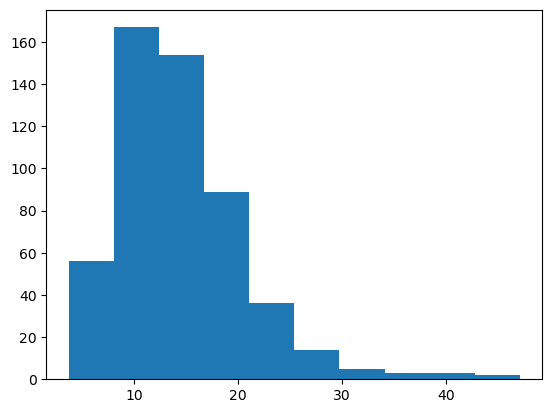

In [12]:
plt.hist(channel_curr)

In [13]:
freqs[0:3]

array([0.      , 1.953125, 3.90625 ])

In [14]:
# z-scoring
for i in range(n_epoch):
    powerSpec[:, :, i] = (powerSpec[:, :, i] - np.mean(baseline, axis=0)
)/np.std(baseline, axis=0)

## MNE demo

In [15]:
from mne.viz import plot_raw_psd
import mne

In [16]:
sample = epochs_behavior['TV']
sample.shape
sampleinfo = mne.create_info([str(id) for id in goodid], 500, 'ecog') 
epochObj = mne.EpochsArray(sample.T, info=sampleinfo)
# epochObj.compute_psd().plot()

Not setting metadata
529 matching events found
No baseline correction applied
0 projection items activated


In [17]:
epochSpec = epochObj.compute_psd()
spectra, samplefreqs = epochSpec.get_data(), epochSpec.freqs

    Using multitaper spectrum estimation with 7 DPSS windows


(0.5, 16.0)

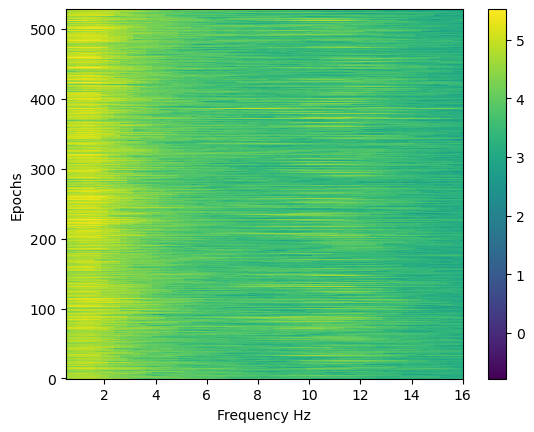

In [18]:
plt.pcolormesh(epochSpec.freqs, np.arange(529), np.log10(spectra[:, 1, :]))
plt.xlabel('Frequency Hz')
plt.ylabel('Epochs')
plt.colorbar()
plt.xlim([0.5, 16])

In [19]:
spectra.shape

(529, 83, 1001)

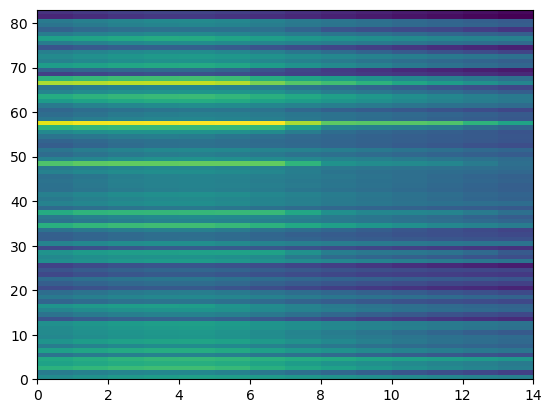

In [20]:
deltaAct = np.mean(spectra[:,:,2:16], axis = 0)
plt.pcolormesh(np.log10(deltaAct))

    Using multitaper spectrum estimation with 7 DPSS windows


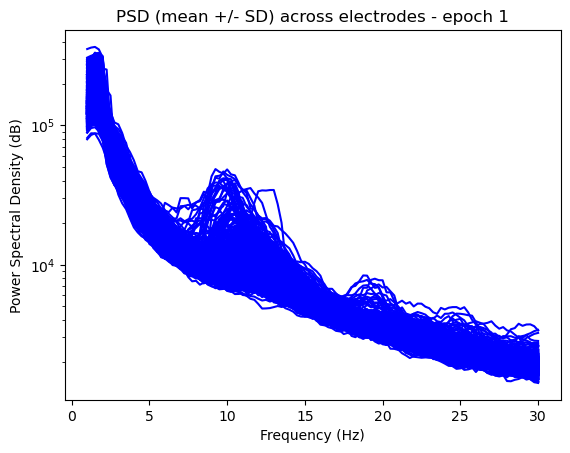

In [24]:
psds, freqs = mne.time_frequency.psd_array_multitaper(sample.T, sfreq=500, fmin=1., fmax=30.)
mean_psd = np.mean(psds, axis=1)
std_psd = np.std(psds, axis=1)
plt.figure()
for i in range(mean_psd.shape[0]):
    plt.semilogy(freqs, mean_psd[i], color='b')
    # plt.fill_between(freqs, mean_psd[i] - std_psd[i], mean_psd[i] + std_psd[i],
                    # color='b', alpha=.2)
plt.title('PSD (mean +/- SD) across electrodes - epoch 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.show()

# Demixed PCA

In [22]:
from dPCA.python.dPCA import dPCA